# Bone Fracture Prediction using EfficientNet

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from skimage.io import imshow
from pathlib import Path
import pandas as pd
import cv2
import keras
import visualkeras
from keras import layers
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [2]:
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [3]:
# Reading the files
fractured_df = pd.read_csv('./dataset_only_fractures.csv')
non_fractured_df = pd.read_csv('./dataset_without_fractures.csv')

# Adding a filepath column to the dataframes
fractured_df['filepath'] = fractured_df['filestem'] + '.png'
non_fractured_df['filepath'] = non_fractured_df['filestem'] + '.png'

#Selecting only the required columns
fractured_df = fractured_df[['filepath', 'fracture_visible']]
non_fractured_df = non_fractured_df[['filepath', 'fracture_visible']]

# Modifying and replacing the NaN values
fractured_df['fracture_visible'] = "positive"
non_fractured_df['fracture_visible'] = "negative"

# Creating the final dataframe with all the values sampled randomly
df = pd.concat([fractured_df, non_fractured_df], axis = 0)
df = df.sample(frac = 1, random_state = 42)
df.reset_index(drop = True, inplace = True)

# Displaying the processed dataframe
df

,filepath,fracture_visible
0,4799_0658553478_01_WRI-L1_M010.png,negative
1,5162_0861552910_02_WRI-L1_M009.png,positive
2,4625_1025941493_01_WRI-L1_F013.png,negative
3,3480_0970508877_01_WRI-L1_M002.png,negative
4,1678_0728816906_01_WRI-R1_F014.png,negative
...,...,...
6984,0218_0891252457_02_WRI-R1_F008.png,negative
6985,2758_0965409258_01_WRI-L1_M010.png,negative
6986,2808_0822762579_01_WRI-R1_F007.png,negative
6987,3120_0954856066_01_WRI-L1_M012.png,negative


In [4]:
from sklearn.model_selection import train_test_split
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# Splitting into train_data and temp_data
train_data, temp_data = train_test_split(df, test_size=1 - train_ratio, random_state=42)
# Splitting temp_data into validation_data and test_data
validation_data, test_data = train_test_split(temp_data, test_size=test_ratio / (test_ratio + validation_ratio), random_state=42)

In [5]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(4193, 2)
(1398, 2)
(1398, 2)


In [6]:
import os
!pwd

/Users/riyavardhan/Downloads/Fracture_dataset


In [7]:
image_datagen = image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
)

batch_size_val = 32
dataset_root = '/Users/riyavardhan/Downloads/Fracture_dataset/images/'

train_ds = image_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = dataset_root,
    x_col = 'filepath',
    y_col = 'fracture_visible',
    target_size = (224,224),
    batch_size = batch_size_val,
    class_mode = 'binary', 
    color_mode = 'grayscale',
    subset='training',
    shuffle=True,
    seed = 42
)

val_ds = image_datagen.flow_from_dataframe(
    dataframe = validation_data,
    directory = dataset_root,
    x_col = 'filepath', 
    y_col = 'fracture_visible',
    target_size = (224,224),
    batch_size = batch_size_val,
    class_mode = 'binary',
    color_mode = 'grayscale',
    shuffle = False
)

test_ds = image_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = dataset_root,
    x_col = 'filepath', 
    y_col = 'fracture_visible',
    target_size = (224,224),
    batch_size = batch_size_val,
    class_mode = 'binary',
    color_mode = 'grayscale',
    shuffle = False
)

Found 4193 validated image filenames belonging to 2 classes.
Found 1398 validated image filenames belonging to 2 classes.
Found 1398 validated image filenames belonging to 2 classes.


In [8]:
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [9]:
base_model = EfficientNetB0(weights='imagenet', include_top=False)

In [10]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [12]:
num_epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs)

Epoch 1/20
132/132 [==============================] - 186s 1s/step - loss: 0.5523 - accuracy: 0.7140 - val_loss: 0.4438 - val_accuracy: 0.7840
Epoch 2/20
132/132 [==============================] - 59s 445ms/step - loss: 0.3918 - accuracy: 0.8235 - val_loss: 0.3626 - val_accuracy: 0.8441
Epoch 3/20
132/132 [==============================] - 59s 447ms/step - loss: 0.3396 - accuracy: 0.8509 - val_loss: 0.3938 - val_accuracy: 0.8062
Epoch 4/20
132/132 [==============================] - 62s 472ms/step - loss: 0.3042 - accuracy: 0.8712 - val_loss: 0.3104 - val_accuracy: 0.8662
Epoch 5/20
132/132 [==============================] - 65s 490ms/step - loss: 0.2900 - accuracy: 0.8743 - val_loss: 0.3195 - val_accuracy: 0.8562
Epoch 6/20
132/132 [==============================] - 65s 489ms/step - loss: 0.2688 - accuracy: 0.8853 - val_loss: 0.2879 - val_accuracy: 0.8770
Epoch 7/20
132/132 [==============================] - 64s 484ms/step - loss: 0.2595 - accuracy: 0.8877 - val_loss: 0.2835 - val_accu

In [13]:
test_loss, test_accuracy = model.evaluate(test_ds)

44/44 [==============================] - 15s 329ms/step - loss: 0.3142 - accuracy: 0.8848


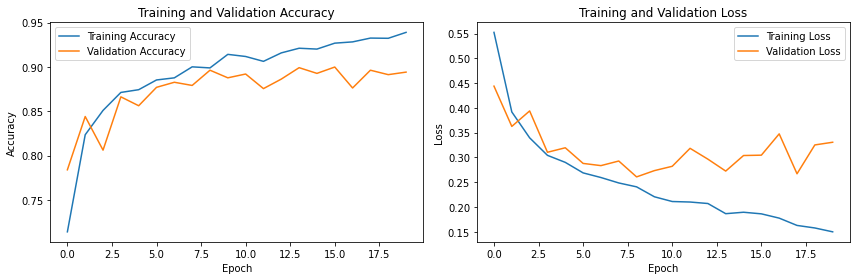

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(figsize=(12, 4))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('training_plots.png')

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [16]:
y_pred = model.predict(test_ds).flatten()  
y_pred_binary = (y_pred > 0.5).astype(int) 

44/44 [==============================] - 38s 599ms/step


In [17]:
cm = confusion_matrix(test_ds.classes, y_pred_binary)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[628  39]
 [120 611]]


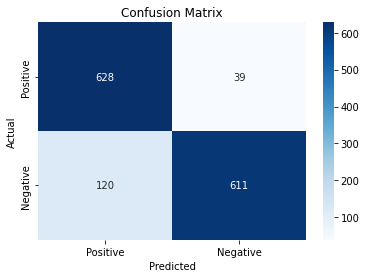

In [19]:
labels = ['Positive', 'Negative'] 
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
report = classification_report(test_ds.classes, y_pred_binary, target_names=labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

    Positive       0.84      0.94      0.89       667
    Negative       0.94      0.84      0.88       731

    accuracy                           0.89      1398
   macro avg       0.89      0.89      0.89      1398
weighted avg       0.89      0.89      0.89      1398

